In [1]:
# modules for importing and manipulating data
import numpy as np 
import pandas as pd 
import re 
import unidecode

# modules for feature selection, modelling and scoring 
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error

# modules for visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt 
import scikitplot as skplt
import seaborn as sns

In [2]:
# recover original matplotlib settings 
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['lightblue', 'black'])
# to display all the columns of the dataframe
pd.pandas.set_option('display.max_columns', 100)

# load data in 
missing_values=["na","missing","n/a","NA","NAN","nan","NaN"]
orders=pd.read_csv("orders.csv",na_values=missing_values)
rest_info=pd.read_csv("restaurants.csv",na_values=missing_values)



In [3]:
# merge both csv files on restaurant_id
df = pd.merge(orders,rest_info, left_on='restaurant_id',right_on='restaurant_id', how='left')
df.drop_duplicates(inplace=True)
df.shape

(32394, 9)

## Data Exploration 

In [4]:
df.head()

,order_acknowledged_at,order_ready_at,order_value_gbp,restaurant_id,number_of_items,prep_time_seconds,country,city,type_of_food
0,2015-06-01 12:28:28.952789+01:00,2015-06-01 14:12:09.474896+01:00,59.90,1326,2,6220,UK,London,burritos
1,2015-06-06 17:06:24.434807+01:00,2015-06-06 17:16:27.520253+01:00,24.00,1326,8,603,UK,London,burritos
2,2015-06-08 14:56:15.503204+01:00,2015-06-08 15:03:39.397496+01:00,15.25,1326,3,443,UK,London,burritos
3,2015-06-12 15:12:20.497925+01:00,2015-06-12 15:23:30.064683+01:00,28.05,1326,8,669,UK,London,burritos
4,2015-06-01 13:07:10.794050+01:00,2015-06-01 14:02:25.104517+01:00,56.30,255,7,3314,UK,London,chinese


In [5]:
# compare unique transactions with unique resturant id's
print('Number of restuarant Id labels: ', len(df['restaurant_id'].unique()))
print('Number of transactions recorded in the Dataset: ', len(df))
print('Avg num of transactions per resturant: ', np.round(len(df)/len(df['restaurant_id'].unique())))

Number of restuarant Id labels:  1697
Number of transactions recorded in the Dataset:  32394
Avg num of transactions per resturant:  19.0


In [6]:
# check if label are missing missing
print("missing target: ",len(df[df['prep_time_seconds'].isna()==True]) )

missing target:  0


#### Missing values

Let's go ahead and find out which variables of the dataset contain missing values.

In [7]:
# make a list of the variables that contain missing values
vars_with_na = [var for var in df.columns if df[var].isnull().sum() > 0]

# determine percentage of missing values
df[vars_with_na].isnull().mean()


Series([], dtype: float64)

Our dataset does not contain variables with missing values. Thus, does not require imputation.




#### Temporal variables

We have 2 date-time-timezone variables in the dataset:

- order_acknowledged_at
- order_ready_at

As we are trying to predict when the order will be ready,we can only use info extracted from the order_acknowledged_at. So we drop the latter to avoid leakage of information.

The info we will extract is:

- year in which the order_acknowledged
- month in which the order_acknowledged
- season in which the order_acknowledged
- day in which the order_acknowledged
- hour in which the order_acknowledged

This is because we generally don't use date variables in their raw format. Instead, we extract information from them. In doing so, the model can capture the effect of season, month or weekday on completion of orders.


In [8]:
def sep_date_from_time(data,cols,drop):
    for i in cols:
            data[i]=data[i].apply(lambda x: re.sub(r'\..*',"",x))
            data[f'year_{i}']=pd.to_datetime(data[i]).dt.year
            data[f'month_{i}']=pd.to_datetime(data[i]).dt.month
            data[f'season_{i}']=data[f'month_{i}']%12 // 3 + 1
            data[f'day_{i}']=pd.to_datetime(data[i]).dt.day_name()
            data[f'hour_{i}']=pd.to_datetime(data[i]).dt.hour
            data.drop([i,drop],inplace=True,axis=1)
    return data


In [9]:
date_time_cols=['order_acknowledged_at']
df=sep_date_from_time(df,date_time_cols,'order_ready_at')         

In [10]:
# Lets make a list of temporal variables 
temporal_cols=[]
names=['year','day_','month_','season_','hour' ]
for col in df.columns:
    for name in names:
        if col.startswith(name)==True:
            temporal_cols.append(col)

In [11]:
# let's explore the values of these temporal variables

for var in temporal_cols:
    print(var, df[var].unique(),df[var].value_counts())

year_order_acknowledged_at [2015] 2015    32394
Name: year_order_acknowledged_at, dtype: int64
month_order_acknowledged_at [6 7] 6    32390
7        4
Name: month_order_acknowledged_at, dtype: int64
season_order_acknowledged_at [3] 3    32394
Name: season_order_acknowledged_at, dtype: int64
day_order_acknowledged_at ['Monday' 'Saturday' 'Friday' 'Wednesday' 'Tuesday' 'Thursday' 'Sunday'] Sunday       5501
Saturday     4929
Friday       4888
Tuesday      4689
Monday       4640
Wednesday    3940
Thursday     3807
Name: day_order_acknowledged_at, dtype: int64
hour_order_acknowledged_at [12 17 14 15 13 21 22 20 18 19 23 10 11  9 16  0  7  8] 20    6691
21    6001
19    4129
22    3640
13    2326
18    1848
14    1795
23    1485
15    1326
17    1158
16    1085
12     749
11     119
0       17
10      16
9        6
8        2
7        1
Name: hour_order_acknowledged_at, dtype: int64


As you can see, three out five columns are redundant. This is because they are unary i.e. for the most case they only have one label. Thus, we can exlude them from our analysis.

We can explore how time taken to prepare is related to the remaining features:

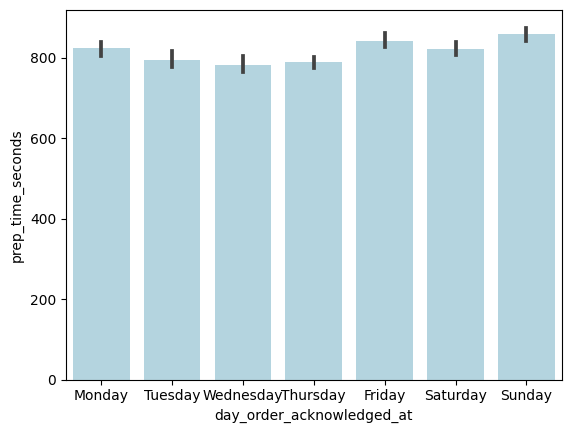

In [12]:
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.barplot(x = 'day_order_acknowledged_at',y='prep_time_seconds', data = df,estimator=np.median, order = day_order,color='lightblue')
plt.show()

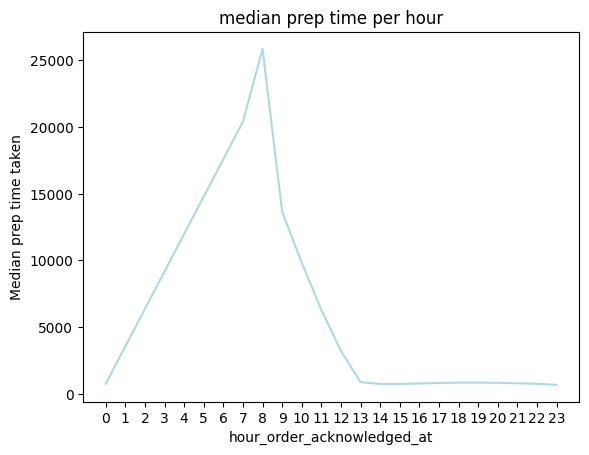

In [13]:
df.groupby('hour_order_acknowledged_at')['prep_time_seconds'].median().plot()
plt.ylabel('Median prep time taken')
plt.title('median prep time per hour')
x = np.arange(0, 24, 1)
plt.xticks(x)
plt.show()

As you can see, Sunday and Friday seem to have the highest median prep time. Also, its quiet intreseting to see that orders that are acknowledge in the moring typically take much longer.

####  Categorical variables

Let's go ahead and analyse the categorical variables present in the dataset.


In [14]:
#  capture categorical variables in a list
cat_vars = [var for var in df.columns if df[var].dtypes == 'O']
print('Number of categorical variables: ', len(cat_vars))

Number of categorical variables:  4


In [15]:
# let's visualise the values of the categorical variables
df[cat_vars].head()

,country,city,type_of_food,day_order_acknowledged_at
0,UK,London,burritos,Monday
1,UK,London,burritos,Saturday
2,UK,London,burritos,Monday
3,UK,London,burritos,Friday
4,UK,London,chinese,Monday


#### Cardinality

Let's evaluate how many different categories are present in each of the variables.

In [16]:
# check for cardinality 
df[cat_vars].nunique()

country                       4
city                         22
type_of_food                 83
day_order_acknowledged_at     7
dtype: int64

In [17]:
# check cardinality of these categorical variables
for col in cat_vars:
    print(str(col), ':' , df[col].value_counts())

country : UK         29689
France      2032
Ireland      353
Germany      320
Name: country, dtype: int64
city : London         25481
Paris           2032
Manchester       964
Brighton         652
Oxford           546
Edinburgh        440
Dublin           353
Berlin           296
Birmingham       278
Leeds            226
Nottingham       226
Cambridge        185
Glasgow          176
Liverpool        156
Reading          127
Guildford        115
Bristol           89
München           24
Cheltenham        11
Leicester         10
Cardiff            5
Southampton        2
Name: city, dtype: int64
type_of_food : italian              4759
burgers              3916
thai                 2891
american             2395
japanese             1776
                     ... 
soup                    3
thaï / brunch           3
ice cream               3
steakhouse              2
japanese peruvian       1
Name: type_of_food, Length: 83, dtype: int64
day_order_acknowledged_at : Sunday       5501
Saturday

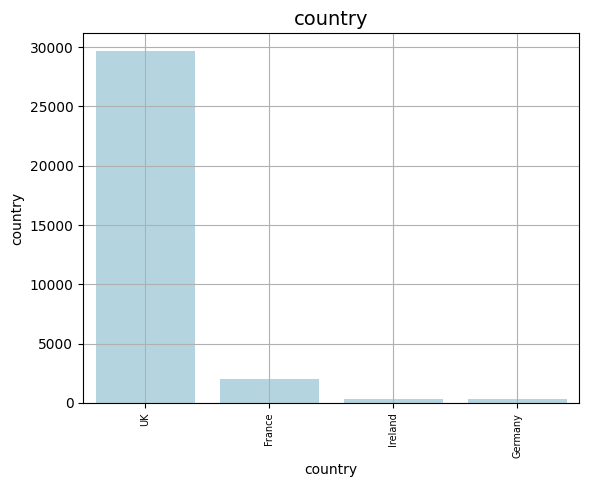

<Figure size 1000x2000 with 0 Axes>

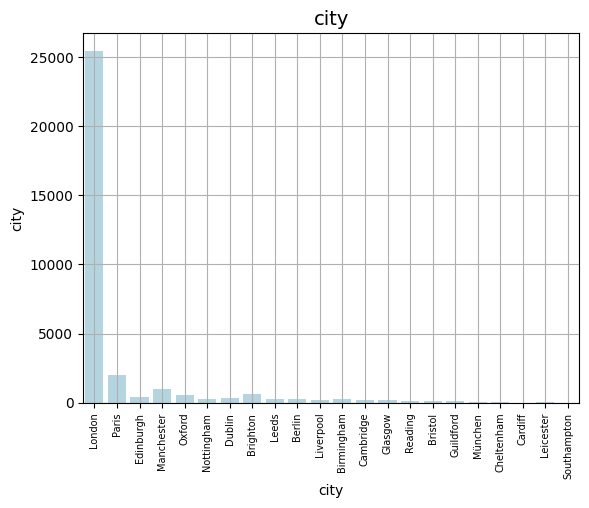

<Figure size 1000x2000 with 0 Axes>

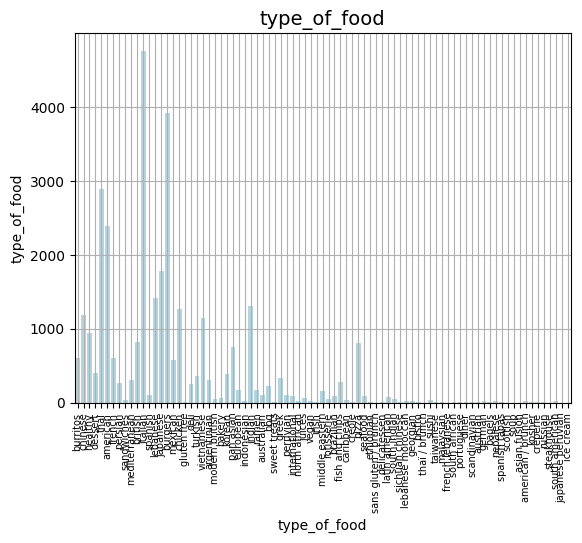

<Figure size 1000x2000 with 0 Axes>

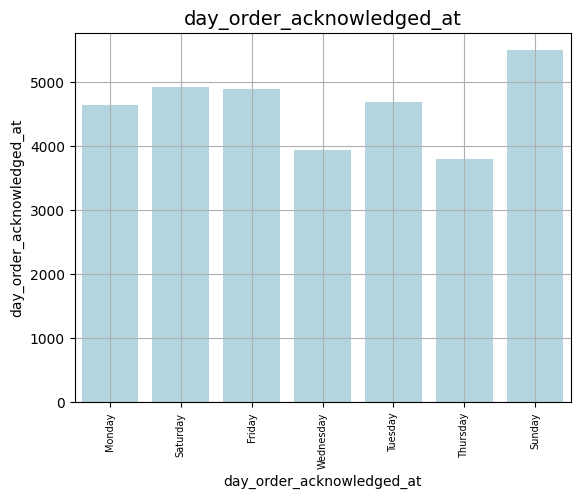

<Figure size 1000x2000 with 0 Axes>

In [18]:
# eyeball distributions of numerical data 
def cat_perclass(data, var):
    sns.countplot(x=var, data=data,color='lightblue');
    plt.title(var,fontsize=14)
    plt.ylabel(var)
    plt.grid(b=None)
    plt.xticks(rotation=90,fontsize=7)
    plt.figure(figsize = (10,20))
    plt.show()



for col in cat_vars:
        cat_perclass(df, col)


Some of the categorical variables show high cardinality, this means that they have alot of different labels. These will be convert to numbers below, using mean target encoding. 

Note: rare labels  i.e. categories that are present in less than x% of the observations, will be grouped togther into a new label called 'Rare'.


#### Rare labels

Let's go ahead and investigate now if there are labels that are present only in a small number of transactions:

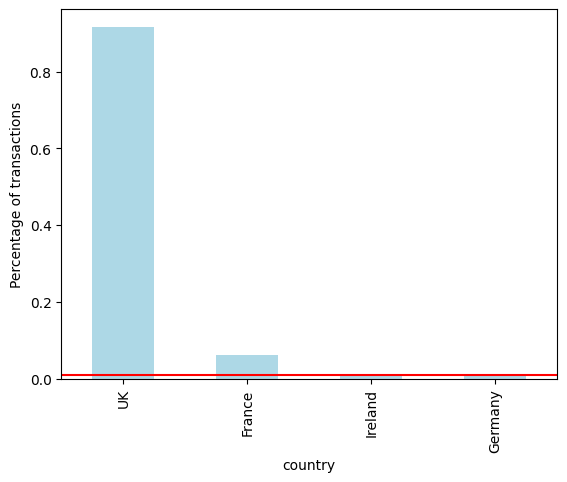

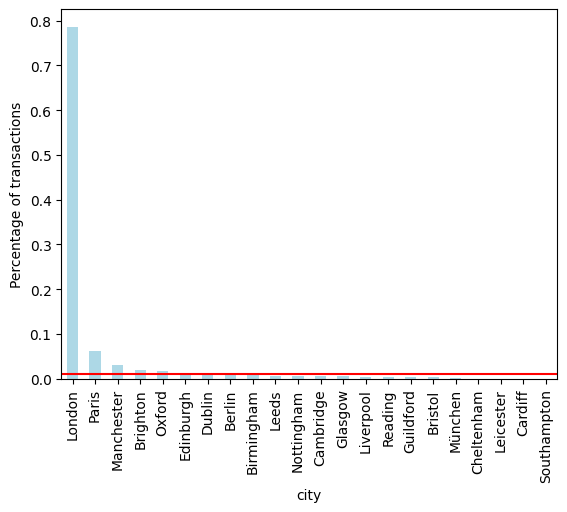

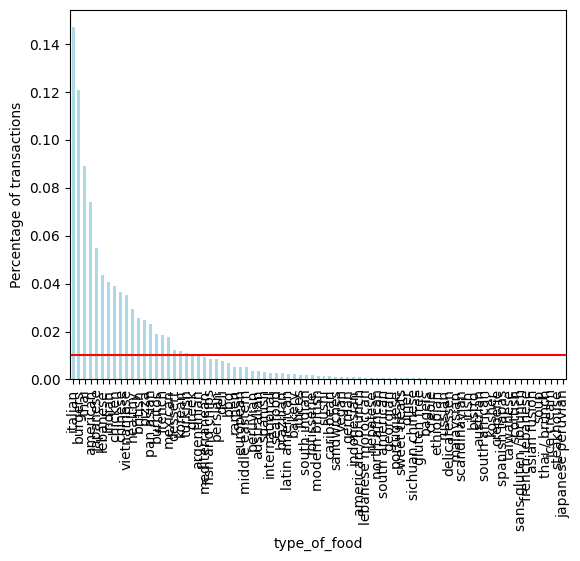

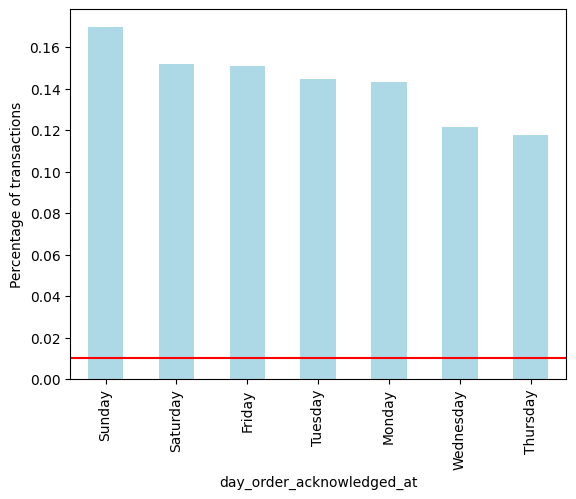

In [19]:
def analyse_rare_labels(data, col, rare_perc):
    data = data.copy()

    # determine the % of observations per category
    temp_df = pd.Series(data[col].value_counts() / len(data) )
    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 1 % to flag the threshold for rare categories
    fig.axhline(y=rare_perc, color='red')
    fig.set_ylabel('Percentage of transactions')
    plt.show()


for var in cat_vars:
    analyse_rare_labels(df, var, 0.01)

#### Discrete variables

Let's go ahead and find which variables are discrete, i.e., show a finite number of values

In [20]:
#   let's make a list of discrete variables
discrete_vars = [var for var in df.columns if len(
    df[var].unique()) < 20 and var not in ['restaurant_id'] and var not in cat_vars]

print('Number of discrete variables: ', len(discrete_vars))

Number of discrete variables:  4


In [21]:
discrete_vars

['year_order_acknowledged_at',
 'month_order_acknowledged_at',
 'season_order_acknowledged_at',
 'hour_order_acknowledged_at']

As shown above, our discrete variables are temporal variables, three of these will be dropped due to them being unary. The relationship between hour variable and preptime is not monotonic. This means there are "higher days" in a numerical sense that don't translate in a higher prep time. This would be a problem for linear models. However, use of trees would mitigate this problem. Alternatively, we can reorder these to match a monotonic relationship.

#### Continuous variables

Let's go ahead and find the distribution of the continuous variables. We will consider continuous variables to all those that are not temporal or discrete variables in our dataset.

In [22]:
# capture all numerical variables in alist 
num_vars = [var for var in df.columns if df[var].dtypes != 'O']

# make list of continuous variables
cont_vars = [
    var for var in num_vars if var not in discrete_vars and var not in temporal_cols+['restaurant_id']]

In [23]:
# check statisics i.e. mean, max, min etc     ... no cont list ..ie. is empty 
df[cont_vars].describe() 

,order_value_gbp,number_of_items,prep_time_seconds
count,32394.000000,32394.000000,32394.000000
mean,26.547303,4.025715,1299.993857
std,19.263851,2.392063,4404.573191
min,0.500000,1.000000,0.000000
25%,16.700000,3.000000,518.000000
50%,21.400000,3.000000,820.000000
75%,30.250000,5.000000,1227.000000
max,711.000000,38.000000,255499.000000


order_value_gbp


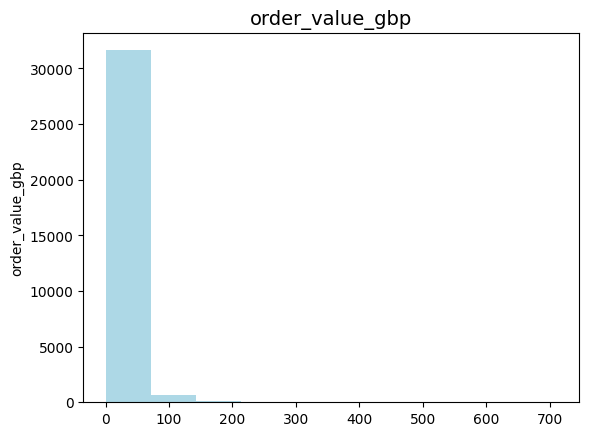

<Figure size 1000x600 with 0 Axes>

number_of_items


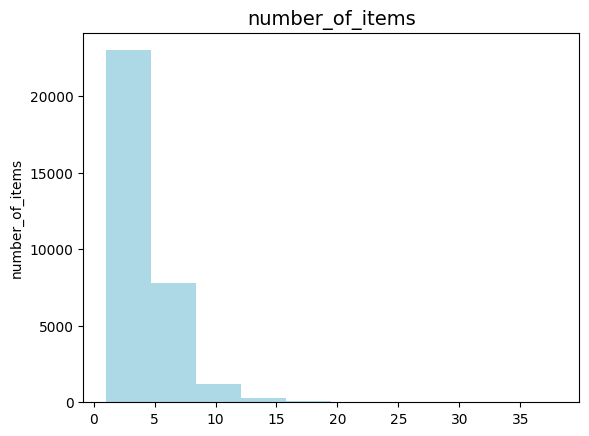

<Figure size 1000x600 with 0 Axes>

prep_time_seconds


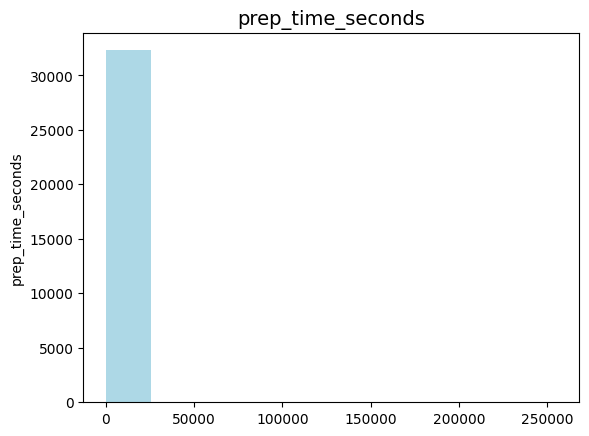

<Figure size 1000x600 with 0 Axes>

In [24]:
# eyeball distributions of numerical data 
def data_distro(data, var):
    data[var].hist()
    plt.title(var,fontsize=14)
    plt.ylabel(var)
    plt.grid(b=None)
    plt.figure(figsize = (10,6))
    plt.show()


for var in cont_vars:
    print(var)
    data_distro(df, var)

The variables are not normally distributed, including the target variable 'prep_time_seconds'. 

To maximise performance of linear models, we need to account for non-Gaussian distributions,using a logarithmic transformation of the variables to return values that follow a normal distribution.

However, this issue will be mitigate by using trees based algorthims. 

#### Outliers

Extreme values may affect the performance models, especially linear models. May also affect how trees split the observations at hand. Let's find out if we have any in our variables.

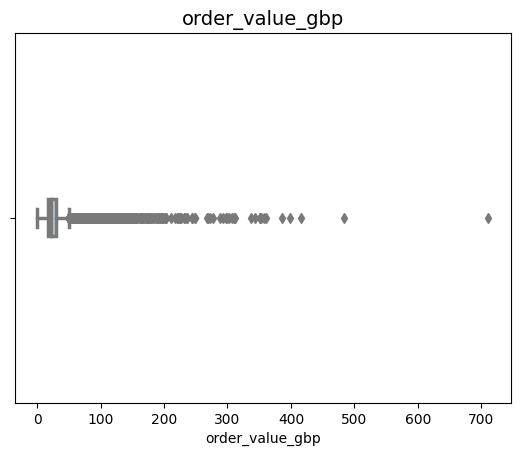

<Figure size 2000x600 with 0 Axes>

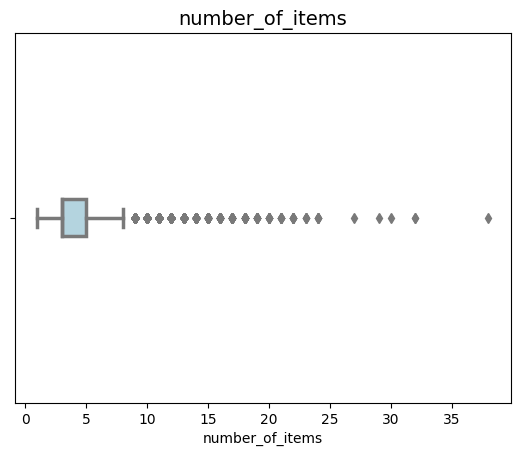

<Figure size 2000x600 with 0 Axes>

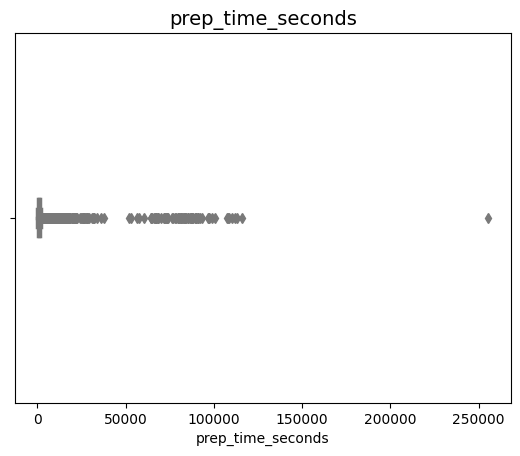

<Figure size 2000x600 with 0 Axes>

In [25]:
#  find outliers within continous data. Important for linear models
# columns with outliers : order_value_gbp, number_of_items, 'prep_time_seconds'
def find_outliers(data, var):
    data = data.copy()
    sns.boxplot(x=data[var],linewidth=2.5,width=0.1)  
    plt.title(var, fontsize=14)
    plt.figure(figsize = (20,6))
    plt.show()


for var in cont_vars:
    find_outliers(df, var)    


#### Correlations

Correlations values may affect the performance and interpretability of our models, especially linear models. 


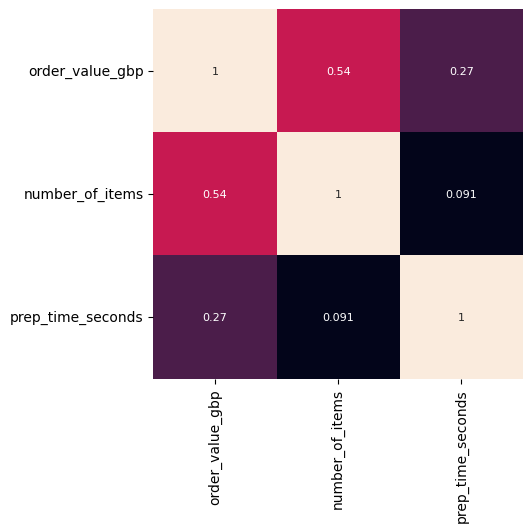

<Figure size 2000x1000 with 0 Axes>

In [26]:
# plot correlations between all the features in the data 
# correlated features:['number_of_items', 'order_value_gbp']
def findCorrfeat(X):
    corr = X.corr()
    #cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    # cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9)
    
    sns.heatmap(
        corr, square = True, cbar = False, cbar_kws = { 'shrink' : 1 }, 
     annot = True, annot_kws = { 'fontsize' : 8 }
    )
    plt.yticks(rotation = 0)
    plt.xticks(rotation = 90) 
    plt.figure(figsize = (20,10))
    plt.show()
    


findCorrfeat(df[cont_vars])

There seems to be a correlation between number of items and order value. Could combine or remove one of these correlated features to limit the contribution and improve interpertability.

In [27]:
def noise_catremoval(data,var,thresh):
    # Get the count of each value
    value_counts = data[var].value_counts()

    # Select the values where the count is less than 3 (or 5 if you like)
    to_remove = value_counts[value_counts <= thresh].index

    # # Keep rows where the city column is not in to_remove
    data = data[~data.type_of_food.isin(to_remove)]
    return data 

In [28]:
for i in ['city','type_of_food']:
    df=noise_catremoval(df,i,10)

In [29]:
df=df[(df.prep_time_seconds<3600)&(df.prep_time_seconds>60)]

## Pre-processing


### Separate dataset into train and test

Before beginning to engineer our features, it is important to separate our data intro training and testing set. When we engineer features, some techniques learn parameters from data. It is important to learn this parameters only from the train set. This is to avoid over-fitting. 


In [30]:
# create training and testing data
X_train, X_test, y_train, y_test = train_test_split(df, df['prep_time_seconds'],
                                                    test_size=0.1,
                                                    random_state=1984)


### Categorical variables
First, we will standardise labels within our categorical features so that two 
words that have the same meaning will be perceived as the same category for 
e.g Newyork and new york will become newyork.

In [31]:
# This is one way to deal with standardisation of categorical features
# 1) convert all letters to lower case.
# 2) remove redundant symbols
# 3) convert letters to unicode
def cleaning_cat_vars(data,var):
    for i in var:
        data[i] = [str(x).lower() for x in data[i]]
        data[i] = data[i].apply(lambda x: re.sub(r'\W', '',x))
        data[i] = data[i].apply(lambda x: unidecode.unidecode(x))
    return data

In [32]:
X_train= cleaning_cat_vars(X_train,cat_vars)
X_test= cleaning_cat_vars(X_test,cat_vars)

### Removing rare labels

First, we will group those categories within variables that are present in less than 1% of the observations. That is, all values of categorical variables that are shared by less than 1% of transactions, well be replaced by the string "Rare".


In [33]:
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the houses in the dataset

    df = df.copy()

    tmp = df.groupby(var).count() / len(df)

    return tmp[tmp > rare_perc].index


for var in cat_vars:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.01)
    
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')

###Encoding of categorical variables

Next, we need to transform the strings of the categorical variables into numbers. We will do it so that we capture the monotonic relationship between the label and the target.

**Ordered Integer Encoding**

Ordering the categories according to the target means assigning a number to the category from 1 to k, where k is the number of distinct categories in the variable, but this numbering is informed by the mean of the target for each category.

**Advantages of target guided encodings** 

- Capture information within the category, therefore creating more predictive features
- Create a monotonic relationship between the variable and the target, therefore suitable for linear models
- Do not expand the feature space


**Limitations**

- Prone to cause over-fitting




In [34]:

def categories_to_ordered(df_train, df_test, cats,target):

    # make a temporary copy of the datasets
    df_train_temp = df_train.copy()
    df_test_temp = df_test.copy()

    for col in cats:

        # order categories according to target mean
        ordered_labels = df_train_temp.groupby(
            [col])[target].mean().sort_values().index

        # create the dictionary to map the ordered labels to an ordinal number
        ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}

        # remap the categories  to these ordinal numbers
        df_train_temp[col] = df_train[col].map(ordinal_label)
        df_test_temp[col] = df_test[col].map(ordinal_label)

    # remove the target
    df_train_temp.drop([target], axis=1, inplace=True)
    df_test_temp.drop([target], axis=1, inplace=True)

    return df_train_temp, df_test_temp


In [35]:
X_train_ordered, X_test_ordered = categories_to_ordered(
    X_train, X_test, cat_vars+discrete_vars,'prep_time_seconds')

X_train_ordered.head()


,order_value_gbp,restaurant_id,number_of_items,country,city,type_of_food,year_order_acknowledged_at,month_order_acknowledged_at,season_order_acknowledged_at,day_order_acknowledged_at,hour_order_acknowledged_at
6666,23.75,2485,2,2,7,22,0,1,0,6,0
25006,17.05,464,3,2,7,30,0,1,0,0,8
10480,13.50,596,2,2,7,4,0,1,0,2,11
26116,16.50,1924,2,2,7,25,0,1,0,4,1
27072,18.00,767,2,2,7,40,0,1,0,6,8


### Outlier capping 


This method works by capping the maximum and /or minimum of a distribution at an arbitrary value. In other words, values bigger or smaller than the determined ones are censored.

Capping can be done at both tails, or just one of the tails, depending on the variable and the user.

The numbers at which to cap the distribution can be determined:

- arbitrarily
- using the inter-quantal range proximity rule
- using the gaussian approximation
- using quantiles


### Advantages

- does not remove data

### Limitations

- distorts the distributions of the variables
- distorts the relationships among variables



In [36]:
def find_boundaries(df, variable):

    # the boundaries are the quantiles

    lower_boundary = df[variable].quantile(0.05)
    upper_boundary = df[variable].quantile(0.95)

    return upper_boundary, lower_boundary

def cap_data(df,upper,lower,var):
    df[var]= np.where(df[var] > upper, upper,
                       np.where(df[var]< lower, lower, df[var]))
    return df 

def apply_capping(df_train,df_test,var):
   
    # make a temporary copy of the datasets
    df_train_temp = df_train.copy()
    df_test_temp = df_test.copy()   
    
    # find boundaries 
    upper_boundary, lower_boundary=find_boundaries(df_train_temp, var)

    # cap train and test data 
    df_train_temp=cap_data(df_train_temp,upper_boundary, lower_boundary,var)
    df_test_temp=cap_data(df_test_temp,upper_boundary, lower_boundary,var)
    return df_train_temp, df_test_temp
  

In [37]:
for i in ['order_value_gbp', 'number_of_items']:
    X_train_ordered, X_test_ordered =apply_capping(X_train_ordered, X_test_ordered ,i)

## Feature selection


### Remove redundant features

Earlier, we identified redundant features that were unary. These should be removed. Additionally, we will drop resturant id as this doesn't help us in our training.

In [38]:
### Remove redundant features

vars_to_drop=["restaurant_id","year_order_acknowledged_at","month_order_acknowledged_at","season_order_acknowledged_at"]

X_train_ordered.drop(vars_to_drop,axis=1,inplace=True)
X_test_ordered.drop(vars_to_drop,axis=1,inplace=True)

### Remove correlated features

recursive feature elimination takes a long time to run, so to speed it up we will reduce the feature space by removing correlated features first.

In [39]:
# find and remove correlated features

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [40]:
corr_features = correlation(X_train, 0.5)
print('correlated features: ', len(set(corr_features)) )

correlated features:  1


In [41]:
corr_features

{'number_of_items'}

In [42]:
# removed correlated  features
X_train_ordered.drop(labels=corr_features, axis=1, inplace=True)
X_test_ordered.drop(labels=corr_features, axis=1, inplace=True)

X_train_ordered.shape, X_test_ordered.shape

((27019, 6), (3003, 6))

### Hybrid method: Recursive feature elimination

This method consists of the following steps:

1) Rank the features according to their importance derived from a machine learning algorithm: it can be tree importance or  coefficients derived from linear models.

2) Remove one feature -the least important- and build a machine learning algorithm utilising the remaining features.

3) Calculate a performance metric of choice

4) If the metric decreases by more of an arbitrarily set threshold, then that feature is important and should be kept. Otherwise, we can remove that feature.

5) Repeat steps 2-4 until all features have been evaluated.


I call this a hybrid method because:

- it derives the importance derived from the machine learning algorithm, like embedded methods
- it builds several machine learning models, like wrapper methods.



In [43]:
# find best features for base model 
dt = DecisionTreeRegressor(
    random_state=1984, max_depth=8, min_samples_split=15)


# recursive feature elimination
selector_dt = RFECV(dt, cv=2)

# fit training data
selector_dt.fit(X_train_ordered, y_train)

# select best features
selected_dt = X_train_ordered.columns[(selector_dt.get_support())]



In [44]:
# find best features for random forest 
rf = RandomForestRegressor(
    n_estimators=800, random_state=1984, max_depth=8, min_samples_split=15, bootstrap=True)

# recursive feature elimination
selector_rf = RFECV(rf, cv=2)

# fit training data
selector_rf.fit(X_train_ordered, y_train)
# select best features
selected_rf = X_train_ordered.columns[(selector_dt.get_support())]

# The following have been changed:

## Model Training 

In [45]:
import xgboost as xgb

In [46]:
best_params = {}
best_score = 1000000
for trees in [500, 700, 1000]:
    model = xgb.XGBRegressor(n_estimators=trees, random_state=1984)
    hyp_opt = GridSearchCV(model, param_grid={'learning_rate': [0.02, 0.03, 0.04], 'max_depth': [3, 4, 5]}, scoring='neg_root_mean_squared_error')
    hyp_opt.fit(X_train_ordered, y_train)
    best_params = hyp_opt.best_params_ if -hyp_opt.best_score_ < best_score else best_params
    best_score = min(best_score, -hyp_opt.best_score_)
    best_params['trees'] = trees
    
print(best_params)
print(best_score)

{'learning_rate': 0.03, 'max_depth': 4, 'trees': 1000}
527.5761122340198


In [47]:
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.03, max_depth=4, random_state=1984)
model.fit(X_train_ordered, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.03, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=1984,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Evaluation 

#### Metrics 

For our metrics, we mainly use: 


1.  Root mean squared error (RMSE) is the square root of the mean of the square of all of the error. The use of RMSE is very common, and it is considered an excellent general-purpose error metric for numerical predictions.

2. Accuracy (100- Mean absloute percentage error) which is often used to assess the prediction accuracy of a forecast. This metric I find is easy to convey to stakeholders.




In [48]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    rmse= np.sqrt(mean_squared_error(predictions,test_labels))
    print('Model Performance')
    print('Average Error: {:0.4f}'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print('RMSE = {}'.format(rmse))
    
    return accuracy,predictions

In [49]:
evaluate(model, X_test_ordered, y_test)

Model Performance
Average Error: 382.7912
Accuracy = 30.28%.
RMSE = 530.8105020106873


(30.282513555378898,
 array([1110.0304 ,  283.46518, 1141.5524 , ...,  977.5249 ,  949.1469 ,
         816.75073], dtype=float32))

### Visual evaluation 

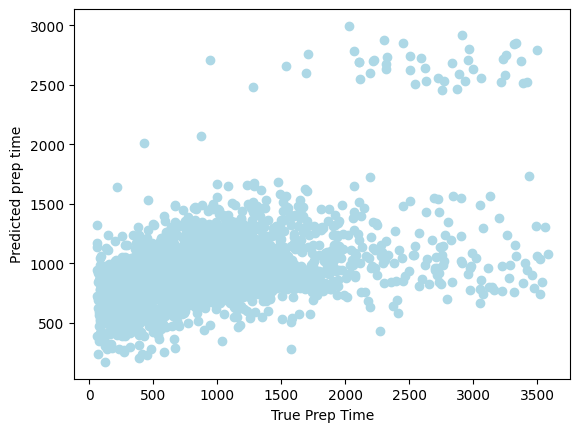

In [50]:
# let's evaluate our predictions respect to the real prep time
plt.scatter(y_test, model.predict(X_test_ordered))
plt.xlabel('True Prep Time')
plt.ylabel('Predicted prep time')
plt.show()

## Conclusion 

Our model does not perform well, the performance metrics are similar to other tried models. This is because our current dataset has a high Bayes error (?). This can be imporoved with better data, e.g., groupings of food types.